# Linguistic Analyses for Compositional Abstractions
## Notebook 1: Exploring abstraction in language about building

This notebook was written by Zoe Tait.  
Original analyses by Will McCarthy, Robert Hawkins, Cameron Holdaway, Haoliang Wang, and Judy Fan.

### *NOTE: THIS NOTEBOOK SERVES AS THE INSTRUCTOR VERSION*

This notebook specifically looks at linguistic analysis and is dvided into two sections, where each section has multiple parts.  
**Section 1** looks at whether or not people become more efficient in their language usage over time.  
**Section 2** looks at in what ways one might become more efficient in their language usage over time.  

### Setup

We will begin by loading in the required packages. Please run the following code.

*Note that you may be missing certain packages. Be sure to install these missing packages before proceeding. Some particular packages that you may be missing include the `NLTK` package (which can be accessed here: https://www.nltk.org/data.html) and the `num2words` package.*

In [1]:
## Run this code to load the required packages

import os
import sys
import urllib, io
os.getcwd()

import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import nltk
from nltk.tokenize import RegexpTokenizer

from nltk.corpus import stopwords
stop = stopwords.words('english')

import num2words
from num2words import num2words

# Section 1: Do people become more efficient in their language usage over time? 

## Part 1.0: Preview the Data

In **Part 1.0** we will preview the data from the paper by reading in two different dataframes that contain the results from the experiment then examining the structure of them. 

*This section is just a preview and it will not include any exercises that need to be completed. While reading this section, begin to think about what questions you may be interested in asking about this data to specifically investigate if people become more efficient in their language usage over time.*

Here is more information about the two dataframes:
- `df_chat`: a dataframe that includes our data and the text instructions from the architects that we are interested in examining
- `df_trial`: a dataframe that includes data on the builder participant accuracy in addition to the text instructions sent by the architexts we are interested in examining

In [2]:
# Run this code to read in the two different dataframes
df_chat = pd.read_csv('../data/df_chat.csv')
df_trial = pd.read_csv('../data/df_trial.csv')

Here, are removing data that didn't meet the accuracy threshold (75% accuracy) as a basic preprocessing step before beginning any analyses.

In [3]:
# Extract data where there is 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

df75 = df75[df75['trials']>=9]
includedGames = list(df75.reset_index().gameid)

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 49


In [4]:
# Exclude the data that did not meet the threshold from analysis
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

Now, we will preview the data.

In [5]:
# Here is a preview of the df_chat dataframe
df_chat.head()

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,repNum,content,timeElapsedInTurn,timeElapsedInTrial,eventType,practice,individualPracticeAttempts,turnStartTime,trialStartTime,flagged
0,0,5ef78389ce2f7f58fcd0a350,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,practice,place the red one 3 from the left and the blue...,60567,60567,chatMessage,True,NaN,NaN,NaN,False
1,1,5ef783bace2f7f58fcd0a358,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,practice,"close, but put the towers starting on the thir...",20018,20018,chatMessage,True,NaN,NaN,NaN,False
2,2,5ef783e4ce2f7f58fcd0a35e,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,0,0,put a blue block three from the left~~~,28166,28166,chatMessage,False,NaN,NaN,NaN,False
3,3,5ef78401ce2f7f58fcd0a365,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,2,0,place a red block on top of the left side of t...,21993,57512,chatMessage,False,NaN,NaN,NaN,False
4,4,5ef7842ace2f7f58fcd0a36e,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,4,0,Now place a blue block on top of that that lin...,24789,98193,chatMessage,False,NaN,NaN,NaN,False


In [6]:
# Here is a preview of the df_trial dataframe
df_trial.head()

,Unnamed: 0,_id,iterationName,gameid,time,assignmentId,leftTarget,rightTarget,trialNum,turnNum,...,cumulativeBonus,eventType,practice,individualPracticeAttempts,flagged,time_final_block,total_block_duration,total_chat_duration,total_duration,diff
0,0,5ef783a1ce2f7f58fcd0a354,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,...,0.00,endTrial,True,NaN,False,NaN,NaN,NaN,NaN,NaN
1,1,5ef783c3ce2f7f58fcd0a35b,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593279e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,vertical,horizontal,NaN,0,...,0.00,endTrial,True,NaN,False,NaN,NaN,NaN,NaN,NaN
2,2,5ef784d6ce2f7f58fcd0a3a0,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,C,Pi,0.0,0,...,0.06,endTrial,False,NaN,False,270221.0,95525.0,163658.0,259183.0,11038.0
3,3,5ef7859cce2f7f58fcd0a3d3,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,C,1.0,0,...,0.16,endTrial,False,NaN,False,191955.0,63542.0,120868.0,184410.0,7545.0
4,4,5ef7863ece2f7f58fcd0a405,pilot0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,1.593280e+12,3E47SOBEYUW78Q4UOK6BV9E6YCECIM,L,Pi,2.0,0,...,0.22,endTrial,False,NaN,False,157681.0,67865.0,87195.0,155060.0,2621.0


## Part 1.1: Analyzing the Efficiency of Language Usage Over Time

In **Part 1.1**, we will be conducting some basic linguistic analyses to understand more about our data and the architects' text instructions within data. We are curious about how people's language usage changes throughout the time course of the task. Specifically, how language usage becomes more efficient. 

One way to go about examining how this may happen is by obtaining a better understanding of both the **word count** and **character count** of the text instructions that the architects sent to the builder. It might be particularly useful examine how these counts changed across trials or across time.

Is there a column in one of the two dataframes that we previously examined that contains information about **word counts** and/or **character counts**? Let us take a further look. 


*Hint: We can also create columns if these do not already exist. Once we have these counts, it may be important to further investigate the amount of text instructions were sent by the architexts. Consider this when writing your code.*

In [7]:
## MASKED FROM STUDENT VERSION

# create a column for word count
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()

# create a column for character count
df_chat['char_count'] = df_chat['content'].str.len()

In [8]:
## MASKED FROM STUDENT VERSION

# df_chat["timeElapsedInTurn"] = pd.to_numeric(df_chat['timeElapsedInTurn'])

# add word count and character count to df_trial dataframe
trial_sums = df_chat[['gameid','trialNum','word_count','char_count']].groupby(['gameid','trialNum']).sum().reset_index()
df_trial = df_trial.merge(trial_sums, how='outer',on=['gameid','trialNum'])

In [9]:
## MASKED FROM STUDENT VERSION

# message counts
counts = df_chat.groupby(['gameid','trialNum'])[['iterationName']].count().reset_index()\
    .rename(columns={'iterationName':'n_messages'})
df_trial = df_trial.merge(counts, how='left', on=['gameid','trialNum'])

### Part 1.2: Visualizing Word Count and Character Count

We have now conducted some basic linguistic analyses to understand more about the potential efficiency in language usage by the architects. 

Now, in **Part 1.2**,  the goal is to further understand this concept by visualizing the analyses we just completed. The goal is to create a plot that looks something like the following (*which visualizes word count*) for both word and character count, visualizing the mean count(s) so that we can understand how these counts change across time.

## INSERT HTML LINK

In [10]:
## MASKED FROM STUDENT VERSION

# group by repNum and create means
repNum_grouped = df_trial.groupby('repNum')
means = repNum_grouped.mean()

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_65687/925959093.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = repNum_grouped.mean()


/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_65687/1193803214.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = repNum_grouped.mean()


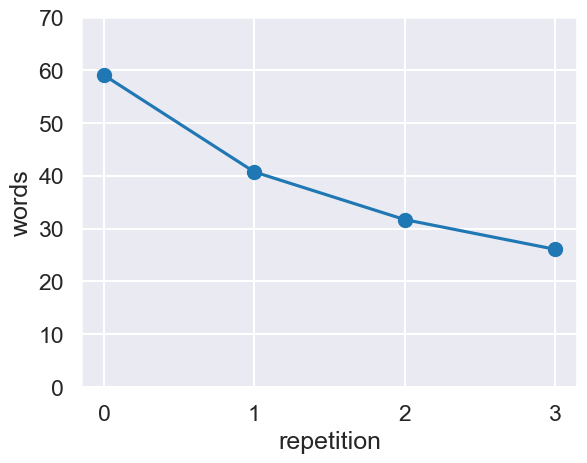

In [11]:
## MASKED FROM STUDENT VERSION

# plot word count over repetitions
repNum_grouped = df_trial.groupby('repNum')
means = repNum_grouped.mean()

plt.plot(means['word_count'], linestyle='-', marker='o', markersize=10)
plt.xlabel('repetition')
plt.ylabel('words')
#plt.xlim(0.5, 4.5)
plt.ylim(0, 70)
plt.show()

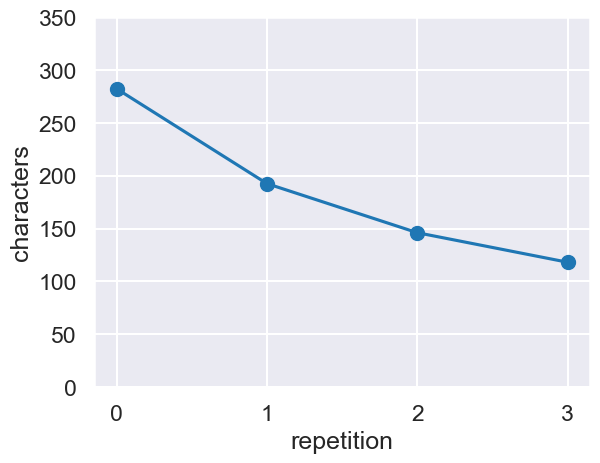

In [12]:
## MASKED FROM STUDENT VERSION

# plot char count over repetitions
plt.plot(means['char_count'], linestyle='-', marker='o', markersize=10)
plt.xlabel('repetition')
plt.ylabel('characters')
#plt.xlim(0.75, 4.25)
plt.ylim(0, 350)
plt.show()

# Section 2: In what ways might one become more efficient in their language usage over time?

While our analyses so far tell us about language use in general, we're primarily interested in how the expressions used to refer to certain entities (*the text instructions*) in our experiment change over time. We have now seen that the participants become more efficient in their language usage over time, but why is that? In particular, we want to know when people transition from providing instructions about lower-level, block by block placements, to higher-level tower abstractions. While we could in principle use NLP techniques to extract noun phrases and assess their meaning, people might use a wide variety of expressions to refer to blocks and towers.  

Because of this, we asked naive raters to **identify the referring expressions** used in each message, as well as the **number of abstractions at each level (block vs. tower)**. In **Section 2**, we will analyze these referring expressions to understand why the participants are becoming more efficient?

## Part 2.0: Preview the Data

In **Part 2.0** we will preview the data from the paper by reading in one dataframe that looks at the referring expression annotations that indicate whether people were transitioning from providing lower-level versus higher-level tower abstractiond. These annotations were completed by the naive raters. We will then examine the structure of this dataframe.

*This section is just a preview and it will not include any exercises that need to be completed. While reading this section, begin to think about what questions you may be interested in asking about this data to specifically investigate in what ways might one become more efficient in their language usage over time.*

In [13]:
# Run this code to read in the referring expressions dataframe
df_ref_exps = pd.read_csv('data/df_ref_exps.csv')

### *Note to anonymize `workerID` before presenting this notebook*

Here is a preview of the `df_ref_exps` dataframe, which includes the referring expression annotations:

In [14]:
# Run this code to preview the df_ref_exps dataframe
df_ref_exps.head()

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1


Here, we preview the referring expressions that were identified by the raters.

In [15]:
# This code looks at the collection of referring expressions identified by raters
df_ref_exps[['message','content','block','tower']].head()

,message,content,block,tower
0,two blue blocks on left and right side of left...,two blue,2,0
1,two blue blocks on left and right side of left...,two blue blocks,2,0
2,two red block on top of left blue block just p...,two red,2,0
3,two red block on top of left blue block just p...,two red block,2,0
4,two red block one space apart on right line,two red,2,0


Here we are converting the `content` column to be of type "string."

In [16]:
# This code to converts the content column to be type string
df_ref_exps.loc[:,'content'] = df_ref_exps.loc[:,'content'].astype(str)

## Part 2.2: Data Processing

Because we are interested in understanding in what ways people become more efficient with their language usage over time, we must further analyze the words included in the text instructions from the architects. To do this, we need to process some of the data in the `df_ref_exps` dataframe. 

To process this data, one step to consider is to remove **(1) stop words**, as they do not make a difference to our analyses. We also want to consider **(2) number words**, for example converting the word "two" to the number "2". We also want to consider **(3) lemmatizing words**, which means obtaining the stem of the word.

*It is important to note that there exists NLP processing libraries that can be used when preprocessing data. To execute the 3 goals listed above, we will be using `NLTK`, which stands for "Natural Language Toolkit." We loaded this package in the beginning of the notebook.*

In [17]:
## MASKED FROM STUDENT VERSION

## STEP 1
# remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_ref_exps['content'].head()

0           two blue
1    two blue blocks
2            two red
3      two red block
4            two red
Name: content, dtype: object

In [18]:
## MASKED FROM STUDENT VERSION

## STEP 2
# convert number words

def num_2_words(sentence):
    out = ""
    for word in sentence.split():
        try:
            o = num2words(word)
        except:
            o = word
        out = out+" "+ o
    return out

df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: num_2_words(x))

In [19]:
## MASKED FROM STUDENT VERSION

## STEP 3
# lemmatize

tokenizer = RegexpTokenizer(r'\w+')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

df_ref_exps['BOW_lemmatized'] = df_ref_exps['content'].apply(lemmatize_text)
df_ref_exps['BOW_lemmatized'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: [i.upper() for i in x])

df_ref_exps[['message','content','BOW_lemmatized']].head()

,message,content,BOW_lemmatized
0,two blue blocks on left and right side of left...,two blue,"[TWO, BLUE]"
1,two blue blocks on left and right side of left...,two blue blocks,"[TWO, BLUE, BLOCK]"
2,two red block on top of left blue block just p...,two red,"[TWO, RED]"
3,two red block on top of left blue block just p...,two red block,"[TWO, RED, BLOCK]"
4,two red block one space apart on right line,two red,"[TWO, RED]"


In [20]:
## MASKED FROM STUDENT VERSION

df_ref_exps['word_freq'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: Counter(x))
df_ref_exps.head()

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep,BOW_lemmatized,word_freq
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1,"[TWO, BLUE]","{'TWO': 1, 'BLUE': 1}"
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1,"[TWO, BLUE, BLOCK]","{'TWO': 1, 'BLUE': 1, 'BLOCK': 1}"
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1,"[TWO, RED, BLOCK]","{'TWO': 1, 'RED': 1, 'BLOCK': 1}"
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"


In [21]:
## MASKED FROM STUDENT VERSION

df_ref_exps['BOW_concat'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: ' '.join(x))

## Part 2.3: Creating Distributions of Words

In Part **2.3**, now that we have preprocessed the dataframe, the goal is to get to the root of our question in that ways in which people become more efficient in their language usage. To do this, it is important to consider the distribution of their words throughout the text instructions and how this distribution may change over time. 

*Hint: Consider caclulating proportions of words and seeing how this changes.*

Our final goal is to plot this data to understand in what ways the participants become more efficient throughout trials, with a plot that looks something like the following:

## INSERT HTML LINK

In [22]:
## MASKED FROM STUDENT VERSION

# **2.3.1** Here, our goal is to convert the word frequencies to proportions. 
# Currently, the word counts represent the counts from all 4 of our naive raters. 
# So that we can examine how frequently different words were used, we need to convert these values into proportions.
split_words = df_ref_exps['BOW_concat'].apply(lambda x: x.split())
all_words = list(pd.Series([st for row in split_words for st in row]).unique())
support = {}
for word in all_words:
    support[word] = 0.000000001
    
def get_pdist(row):
    num_words = np.sum(list(row['word_freq'].values()))
    pdist = support.copy()
    for i, (word, count) in enumerate(row['word_freq'].items()):
        pdist[word] = count/num_words
    return pdist

In [23]:
## MASKED FROM STUDENT VERSION

df_ref_exps['word_pdist'] = df_ref_exps.apply(get_pdist, axis = 1)
df_ref_exps['word_pdist_numeric'] = df_ref_exps['word_pdist'].apply(lambda dist: list(dist.values()))

In [24]:
## MASKED FROM STUDENT VERSION

df_all_words = df_ref_exps[['dyad_gameid', 'rep', 'BOW_concat']]

In [25]:
## MASKED FROM STUDENT VERSION

for w in all_words:
    df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_65687/999219942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_65687/999219942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_65687/999219942

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_65687/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_65687/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_65687/999219942.py:2: PerformanceWarn

In [26]:
## MASKED FROM STUDENT VERSION

df_all_words_reps = df_all_words.groupby('rep').agg(sum)
df_all_words_reps

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_65687/3932202342.py:1: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df_all_words_reps = df_all_words.groupby('rep').agg(sum)


,TWO,BLUE,BLOCK,RED,ONE,EXACT,CONSTRUCTION,LEFT,RIGHT,SIDE,...,OUSE,TILE,BLOC,SHAP,HORIZTONAL,MAKE,ANGLE,CENTRED,LEFTMOST,TWR
rep,,,,,,,,,,,,,,,,,,,,,
1,623,1085,1100,1035,224,0,0,3,5,9,...,0,3,1,0,2,1,1,1,0,0
2,512,1129,499,979,184,5,3,11,10,13,...,0,0,0,1,0,0,0,0,1,1
3,320,868,181,777,131,0,0,5,7,7,...,1,1,0,0,0,0,0,0,0,0
4,75,209,35,184,20,0,0,2,1,2,...,0,0,0,0,0,0,0,0,0,0


In [27]:
## MASKED FROM STUDENT VERSION

# examine the change in word frequencies between trials.
# prep data
df_ref_exps_rep = df_ref_exps.groupby('rep')['BOW_concat'].apply(lambda group:' '.join(group)).reset_index()
df_ref_exps_rep['word_freq'] = df_ref_exps_rep['BOW_concat'].apply(lambda x: Counter(x.split()))
df_ref_exps_rep['word_pdist'] = df_ref_exps_rep.apply(get_pdist, axis=1)
df_ref_exps_rep['word_pdist_numeric'] = df_ref_exps_rep['word_pdist'].apply(lambda dist: list(dist.values()))
df_ref_exps_rep.index=df_ref_exps_rep['rep']

In [28]:
## MASKED FROM STUDENT VERSION

# calculate difference in proportion between reps

rep_a = 1
rep_b = 4

rep_diff = {}

for _, (k, rep_a_v) in enumerate(df_ref_exps_rep.loc[rep_a,'word_pdist'].items()):
    rep_diff[k] = df_ref_exps_rep.loc[rep_b,'word_pdist'][k] - rep_a_v

In [29]:
## MASKED FROM STUDENT VERSION

# find largest n increase/ decrease in proportion across reps
n = 6

In [30]:
## MASKED FROM STUDENT VERSION

# find the largest increase in proportion between reps
top_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=True)[:n])

top_n

{'L': 0.05734655611812832,
 'C': 0.03298536181665175,
 'SHAPE': 0.032698562616607654,
 'BLUE': 0.02154686921943194,
 'U': 0.020250494326782383,
 'TALL': 0.01816359509904137}

In [31]:
## MASKED FROM STUDENT VERSION

# find the largest decrease in proportion between reps

bottom_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=False)[:n])

bottom_n

{'BLOCK': -0.15443041001392815,
 'TWO': -0.03777088343850854,
 'HORIZONTAL': -0.02285785639184289,
 'ONE': -0.01672335567019553,
 'VERTICAL': -0.01624128327697643,
 'RED': -0.009534645383217022}

In [32]:
## MASKED FROM STUDENT VERSION

df_grouped = df_ref_exps.groupby('rep').agg({'BOW_lemmatized': 'sum'})

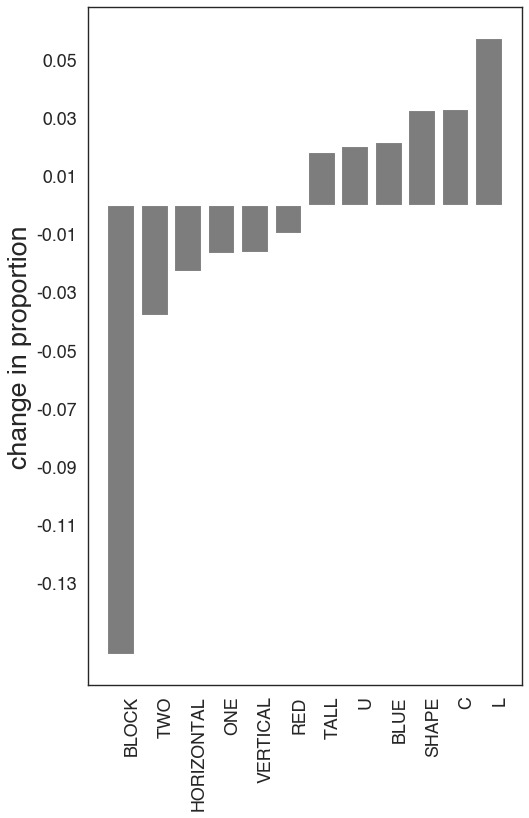

In [33]:
## MASKED FROM STUDENT VERSION

from matplotlib.ticker import FormatStrFormatter

font = {'fontname':'Helvetica'}
sns.set_theme(style='white')

x_limit = 6

labels, values = zip(*rep_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange your data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))

bar_width = 0.35

fig = plt.figure(num=None, figsize=(7, 11), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.bar(indexes, values, color = "#7D7D7D")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# add labels
plt.yticks(fontsize=16, **font)
plt.xticks(indexes + bar_width, labels,  rotation='vertical', fontsize=16, **font)
plt.ylabel("change in proportion", size = 24, **font)
plt.yticks(np.arange(-.13,.06, .02))
ax.axes.get_xaxis().set_visible(True)
#plt.title("highest delta words", size = 24, **font)
plt.show()

### Summary

We've seen that participants' language became more concise as they reconstructed the same towers with the same partner. This trend was accompanied by an shift in the abstraction level of referring expressions, from lower-level expressions referring to individual blocks, to higher-level expressions that encompassed entire towers.

Well done! You're all done with Notebook 1! Take a break, rest your eyes, have a snack.

In the [next notebook](/notebooks/ca_programs.ipynb), we begin to explain this process by modeling the learning of part concepts with program abstraction.